In [ ]:
#code is used from these 3 repositories, have a look at them on GitHub or access the files from colab
!git clone https://github.com/PeterWang512/FALdetector
!git clone https://github.com/NVIDIA/flownet2-pytorch.git
!git clone https://github.com/Kwanss/PCLNet

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 25 10:32:09 2020

@author: peter fazekas
"""
#import necessary modules and append paths 

import os
import csv
import pickle
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/FALdetector/networks/")
sys.path.append("/content/FALdetector/")
from drn_seg import DRNSeg
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss,BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
sys.path.append("/content/flownet2-pytorch/")
import losses
from losses import MultiScale,EPE
sys.path.append("/content/PCLNet/Losses/")
sys.path.append("/content/PCLNet/models/")
from utils.tools import *
from utils.visualize import *
import pandas as pd
import numpy as np
import torch.nn as nn
# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from torchsummary import summary

this is my auth code for colab so I dont need to sign in every time:

 4/1AY0e-g7sNnaE3ipL5zPchnJROOIo3hlzHxzAooMPub6pr9xolemUBGC_7J4

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
!unzip /mydrive/nofakes/flow_pred_data/modified.zip -d modif
!unzip /mydrive/nofakes/flow_pred_data/reference.zip -d ref
!unzip /mydrive/nofakes/flow_pred_data/local_weight.zip

In [ ]:
pathM =r"/content/modif"
path =r"/content/ref"

#if you guys can come up with a more efficient way to do this go ahead.
height =400
width=400
#variable to control how many training examples to import
train_size =10
filenames = []

#Redo this part.... it doesnt import training images in order, I have printed out the filenames imported for convenience
def createTrain(path,n_images):
    arr=[]
    counter =0
    for r,d,f in os.walk(path):
        for _file in f:
            if '.png' in _file:
                #print(_file)
                img = cv2.imread(r""+path+"/"+str(_file))
                filenames.append(path+"/"+str(_file))
                #keep image dimensions at 500 for now
                img = cv2.resize(img, (width,height), interpolation = cv2.INTER_AREA)
                #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                arr.append(img)
                counter+=1
                #terminate once we imported the desired number of images
                if(counter==n_images):
                    return np.array(arr)
                    

X_ref=createTrain(path,train_size)
X_mod = createTrain(pathM,train_size)

print("the filenames are",filenames)
shape = X_ref.shape

the filenames are ['/content/ref/flickr_0537.png', '/content/ref/flickr_0536.png', '/content/ref/flickr_0589.png', '/content/ref/flickr_0596.png', '/content/ref/flickr_0517.png', '/content/ref/flickr_0535.png', '/content/ref/flickr_0581.png', '/content/ref/flickr_0586.png', '/content/ref/flickr_0504.png', '/content/ref/flickr_0593.png', '/content/modif/flickr_0537.png', '/content/modif/flickr_0536.png', '/content/modif/flickr_0589.png', '/content/modif/flickr_0596.png', '/content/modif/flickr_0517.png', '/content/modif/flickr_0535.png', '/content/modif/flickr_0581.png', '/content/modif/flickr_0586.png', '/content/modif/flickr_0504.png', '/content/modif/flickr_0593.png']


In [ ]:
flow_arr =[]
#calcOptical gives an error if I input all training data at once (doesnt seem very efficient atm)
for i in range(shape[0]):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(X_ref[i],cv2.COLOR_BGR2GRAY), cv2.cvtColor(X_mod[i],cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
    flow_arr.append(flow)    
print(X_mod.shape)
flow_arr = np.array(flow_arr)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
print(mag.shape)
path = "tester_before_train.png"
tester = save_heatmap_cv(X_mod[0], mag, path)
#print(flow)
print("flow arr has shape",flow_arr.shape)
#the code below is pretty similar to how the binary classifier is trained with a few changes 
#since the output shape is (2,height,width) for the vector field

(10, 400, 400, 3)
(400, 400)
flow arr has shape (10, 400, 400, 2)


**Discretize the flow fields**

In [322]:
print("maximum flow value is: ",np.max(flow_arr))
print("minimum flow value is: ",np.min(flow_arr))
categorical_flow =[]
dic ={}
counter =0
#create a placeholder for the (u,v)->class pairs, hashmap is the easiest as its O(1) lookup time for the values
#Note when obtaining flow values from classes it takes O(n) time to look up each one, not very efficient so
#maybe re-do this part so that the hashmap key-value pairs are {class_pairs:(u,v)}

#max and minimum allowed flow values
max_f =5
min_f=-5
#fill up hashmap with values
for i in range(min_f,max_f+1):
  for j in range(min_f,max_f+1):
    dic[i,j]=counter
    counter+=1
print(len(dic))
print("this is what the hashmap looks like",dic)
dimens= flow_arr.shape

#categorise the flow into distinct values
for flows in flow_arr:
  temp_flow =np.zeros((dimens[1],dimens[2]))
  print(temp_flow.shape)
  for i in range(dimens[1]):
    for j in range(dimens[2]):
      value = flows[i][j]
      #makes sure we are not going over the max and min values 
      if (value[1]>max_f or value[1]<min_f or value[0]>max_f or value[0]<min_f):
        continue
      temp_flow[i][j]=dic[int(value[0]),int(value[1])]
      
  categorical_flow.append(temp_flow)
categorical_flow = np.array(categorical_flow)
#print(categorical_flow.shape)
#print(categorical_flow[0][0])

maximum flow value is:  63.448624
minimum flow value is:  -32.35947
121
{(-5, -5): 0, (-5, -4): 1, (-5, -3): 2, (-5, -2): 3, (-5, -1): 4, (-5, 0): 5, (-5, 1): 6, (-5, 2): 7, (-5, 3): 8, (-5, 4): 9, (-5, 5): 10, (-4, -5): 11, (-4, -4): 12, (-4, -3): 13, (-4, -2): 14, (-4, -1): 15, (-4, 0): 16, (-4, 1): 17, (-4, 2): 18, (-4, 3): 19, (-4, 4): 20, (-4, 5): 21, (-3, -5): 22, (-3, -4): 23, (-3, -3): 24, (-3, -2): 25, (-3, -1): 26, (-3, 0): 27, (-3, 1): 28, (-3, 2): 29, (-3, 3): 30, (-3, 4): 31, (-3, 5): 32, (-2, -5): 33, (-2, -4): 34, (-2, -3): 35, (-2, -2): 36, (-2, -1): 37, (-2, 0): 38, (-2, 1): 39, (-2, 2): 40, (-2, 3): 41, (-2, 4): 42, (-2, 5): 43, (-1, -5): 44, (-1, -4): 45, (-1, -3): 46, (-1, -2): 47, (-1, -1): 48, (-1, 0): 49, (-1, 1): 50, (-1, 2): 51, (-1, 3): 52, (-1, 4): 53, (-1, 5): 54, (0, -5): 55, (0, -4): 56, (0, -3): 57, (0, -2): 58, (0, -1): 59, (0, 0): 60, (0, 1): 61, (0, 2): 62, (0, 3): 63, (0, 4): 64, (0, 5): 65, (1, -5): 66, (1, -4): 67, (1, -3): 68, (1, -2): 69, (1, -1):

In [323]:
#Sanity check to make sure shapes add up

#print(categorical_flow.shape)
#print(categorical_flow[0][100])

In [324]:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [325]:
#check if GPU is available
cuda0 = torch.device('cuda:0')

if torch.cuda.is_available():
    device = 'cuda:{}'.format("cuda:0")
else:
    device = 'cpu'


model = DRNSeg(2)
device = torch.device(cuda0)
#state_dict = torch.load("local.pth", map_location=device)
#model.load_state_dict(state_dict['model'])
model.to(device)
summary(model, (3, height, width))


  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]           2,352
       BatchNorm2d-2         [-1, 16, 400, 400]              32
              ReLU-3         [-1, 16, 400, 400]               0
            Conv2d-4         [-1, 16, 400, 400]           2,304
       BatchNorm2d-5         [-1, 16, 400, 400]              32
              ReLU-6         [-1, 16, 400, 400]               0
            Conv2d-7         [-1, 16, 400, 400]           2,304
       BatchNorm2d-8         [-1, 16, 400, 400]              32
              ReLU-9         [-1, 16, 400, 400]               0
       BasicBlock-10         [-1, 16, 400, 400]               0
           Conv2d-11         [-1, 32, 200, 200]           4,608
      BatchNorm2d-12         [-1, 32, 200, 200]              64
             ReLU-13         [-1, 32, 200, 200]               0
           Conv2d-14         [-1, 32, 2

In [ ]:
temp = torch.randn(1, 3, 200, 200)
temp = temp.cuda()
sizes =[2,4,16,32,64,121]
# Let's print it
shape=model(temp).shape
print(shape)

#leave it out for now as I am using the DRNSeg(121)
if False:
  perPix_model = nn.Sequential(model,nn.ReLU(),
                              nn.Conv2d(sizes[0],sizes[1],kernel_size=(1,1)).cuda(),nn.ReLU(),
                              nn.Conv2d(sizes[1],sizes[2],kernel_size=(1,1)).cuda(),nn.ReLU(),
                              nn.Conv2d(sizes[2],sizes[3],kernel_size=(1,1)).cuda(),nn.ReLU(),
                               nn.Conv2d(sizes[3],sizes[4],kernel_size=(1,1)).cuda(),nn.ReLU(),
                               nn.Conv2d(sizes[4],sizes[5],kernel_size=(1,1)).cuda(),
                              nn.Tanh()
                              )
#just add a tanh activation onto it
perPix_model = DRNSeg(len(dic)).to(device)
summary(perPix_model, (3, height, width))
perPix_model.to(device)

**Training the Classifier**

In [ ]:
#changed crossentropy to MSE since cross entropy needs classes, we arent doing classification
#other losses might work much better 
optimizer = Adam(model.parameters(),lr=0.07) 
criterion =torch.nn.MSELoss()
criterion_classif = nn.CrossEntropyLoss()




#criterion = MultiScale(model)
if torch.cuda.is_available():
  model = model.cuda()
  perPix_model =perPix_model.cuda()
  criterion = criterion.cuda()
  criterion_classif=criterion_classif.cuda()
#convert to torch format
train_x = X_mod
train_x_orig=X_ref
train_x = train_x.reshape(train_size,3, height, width)
train_x_orig = train_x_orig.reshape(train_size,3, height, width)
print("train_x has shape",train_x.shape)
train_x  = torch.from_numpy(train_x)

#train_x_orig  = torch.from_numpy(train_x_orig).float()


# converting the target into torch format
train_y=flow_arr



cat_shape = categorical_flow.shape
categorical_flow = categorical_flow.reshape(train_size,height,width)
categorical_label=torch.from_numpy(categorical_flow)
train_y = train_y.reshape(train_size,2,height,width)
print("train_y has shape: ",train_y.shape)
train_y = torch.from_numpy(train_y).float()






#this part of the code trains the classifier called perPix_model
def train_classif(epoch):
    perPix_model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_categorical = Variable(train_x), Variable(categorical_label)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_categorical = y_categorical.cuda()
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = perPix_model(x_train.float()).float()
    
   
    #resize y_hat to have the correct shape for cross entropy
    #flattening like this works for some reason
    y_hat = torch.flatten(output_train,start_dim=2,end_dim=3)
    #print(y_hat.shape)
    y_hat = torch.transpose(y_hat,1,2)
    #print(y_hat.shape)
    y_hat = torch.flatten(y_hat,start_dim=0,end_dim=1)
    
    output_val =torch.argmax(y_hat, dim=1)
    
    #flatten the categorical ground truths as well (y_categorical)
    correct = (abs(output_val==torch.flatten(y_categorical).long())).float().sum()/(output_val.shape[0])
    

    total = train_size
    #here we flatten again
    Loss= criterion_classif(y_hat,torch.flatten(y_categorical).long())
    
    #print(Loss)
    train_losses.append(Loss)
    
    # computing the updated weights of all the model parameters
    Loss.backward()
    optimizer.step()
    tr_loss = Loss.item()
    if epoch%100 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :',Loss.item(),"accuracy: ",correct.item())
        torch.set_printoptions(edgeitems=10)
        print(torch.argmax(y_hat,dim=1))
        print(y_categorical.resize(height*width*train_size))
        print(torch.argmax(y_hat,dim=1).shape)
        print(y_categorical.resize(height*width*train_size).shape)
        print("\n")

train_x has shape (1, 3, 400, 400)
train_y has shape:  (1, 2, 400, 400)


In [ ]:
n_epochs = 10000
train_losses =[]
correct =0
#same parameters the FAL paper have used
optimizer = Adam(perPix_model.parameters(),lr=0.0001,betas =(0.9,0.999))
for epoch in range(n_epochs):
    train_classif(epoch)
    

**plots the training loss**

225


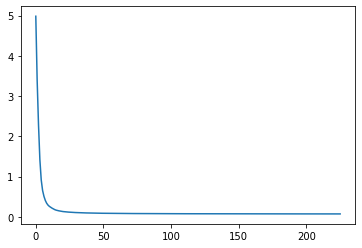

In [ ]:
 print(len(train_losses))
iter = np.linspace(0,len(train_losses),len(train_losses))
plt.plot(iter,train_losses)
plt.show()


**Training the regression, skip these blocks for now**

In [ ]:
MS_criterion= MultiScale(model)
EPE_l,MS_l,REC_l=1.5,15,1

#the function below is very messy atm, im just happy that it works, it needs to be cleaned up though
#it just converts and reshapes tensors to numpy arrays and vica versa during training for the recreational loss

#creates the recreation loss, unwarps image and compares with the original image
def rec_loss(output_train,x_train,x_train_orig):
    output_np = output_train.cpu()
    #print(output_np.shape)
    
    #get shapes of output and convert/reshape into np array
    with torch.no_grad():
      output_np = np.array(output_np)  
    shape = output_np.shape
    output_np =np.reshape(output_np,(shape[0],shape[2],shape[3],shape[1]))
    

    #get shapes of x_train and convert/reshape into np array
    x_train_np = x_train.detach().cpu().numpy()
    shape2 =x_train_np.shape
    x_train_np =np.reshape(x_train_np,(shape2[0],shape2[2],shape2[3],shape2[1]))


    #print(x_train_np.shape,type(x_train_np))
    x_warped=[]
    #undo the warps using prediction flow field and manipulated image
    for i in range(train_size):
      x_warped.append(warp(x_train_np[i],output_np[i]))
    #convert from torch to numpy and reshape
    x_warped = np.array(x_warped)
    shape_warp = x_warped.shape

    #get unwarped image and turn it into torch format
    x_warped = np.reshape(x_warped,(shape_warp[0],shape_warp[3],shape_warp[1],shape_warp[2]))
    x_warp_tens = torch.from_numpy(x_warped).float()
    #turn it into cuda tensor
    if torch.cuda.is_available():
      x_warp_tens = x_warp_tens.cuda()
    #return the norm of the warped image-original image as the loss
    return torch.norm(x_warp_tens-x_train_orig,p=2,dim=1).mean()



def train_regress(epoch,EPE_l,MS_l,REC_l):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_train_orig=Variable(train_x_orig)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_train_orig=x_train_orig.cuda()  
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    print("output train shape",output_train.shape)
    print(output_train)
    total = train_size
    # computing the training and validation loss
    #print(x_train.shape)
    #print(output_train.shape)
    print("y train shape",y_train.shape)
    print(y_train)
    REC_loss = rec_loss(output_train,x_train,x_train_orig)
    EPE_loss_train = EPE(output_train,y_train.float())
    MS_loss_train,_ = MS_criterion(output_train, y_train.float())
    
    loss_train=EPE_l*EPE_loss_train+MS_l*MS_loss_train +REC_l*REC_loss 
    train_losses.append(loss_train)
    
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :',loss_train.item(),"accuracy: ")
        print("epe: ",EPE_loss_train.item()," MS: ",MS_loss_train.item()," reconstruct: ",REC_loss.item())
        print("\n")

In [ ]:
n_epochs = 500
train_losses =[]
correct =0
#same parameters the FAL paper have used
optimizer = Adam(model.parameters(),lr=0.0001,betas =(0.9,0.999)) 
for epoch in range(n_epochs): 
    train_regress(epoch,EPE_l,MS_l,REC_l)

In [305]:
#function to
def get_heatmap_cv(img, magn, max_flow_mag):
    min_flow_mag = .5
    cv_magn = np.clip(
        255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),
        a_min=0,
        a_max=255).astype(np.uint8)
    if img.dtype != np.uint8:
        img = (255 * img).astype(np.uint8)
        
    heatmap_img = cv2.applyColorMap(cv_magn, cv2.COLORMAP_MAGMA)
    heatmap_img = heatmap_img[..., ::-1]
    h, w = magn.shape
    img_alpha = np.ones((h, w), dtype=np.double)[:, :, None]
    heatmap_alpha = np.clip(
        magn / max_flow_mag, a_min=0, a_max=1)[:, :, None]**.7
    heatmap_alpha[heatmap_alpha < .2]**.5
    pm_hm = heatmap_img * heatmap_alpha
    pm_img = img * img_alpha
    cv_out = pm_hm + pm_img * (1 - heatmap_alpha)
    cv_out = np.clip(cv_out, a_min=0, a_max=255).astype(np.uint8)
    return cv_out

def save_heatmap_cv(img, magn, path, max_flow_mag=2):
    cv_out = get_heatmap_cv(img, magn, max_flow_mag)
    out = Image.fromarray(cv_out)
    plt.imshow(out)
    plt.show()
    out.save(path, quality=95)
    return out

In [306]:
from utils.tools import *
from utils.visualize import *


import torchvision.transforms as transforms
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

In [333]:
#quick sanity check again

#print(flow.shape)
#print(pic.size)

**uses training image to predict the flow field**

In [332]:
test_ref = X_ref[0]
test_mod = X_mod[0]
ground_flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(test_ref,cv2.COLOR_BGR2GRAY), cv2.cvtColor(test_mod,cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
image = np.array([test_mod])

shapes = image.shape

image = np.reshape(image,(shapes[0],shapes[3],shapes[1],shapes[2]))
image_tensor = torch.from_numpy(image)
image_tensor= Variable(image_tensor)
# converting the data into GPU format
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()
with torch.no_grad():
        flow = perPix_model(image_tensor.float()).cpu().numpy()
        flow = np.argmax(flow,1)
        flow = np.reshape(flow,(shapes[1],shapes[2]))
        #print(flow.shape)
        #print(flow)
        real_flow = np.zeros((2,400,400))
        temp =0
        for i in range(shapes[1]):
          for j in range(shapes[2]):
            real_flow[:,i,j]=list(dic.keys())[list(dic.values()).index(flow[i][j])]
        #print(real_flow.shape)
        np.set_printoptions(edgeitems=3)
        #print(real_flow)
        real_flow = np.transpose(real_flow, (1, 2, 0))
        #print(real_flow.shape)
        w, h, _ = real_flow.shape

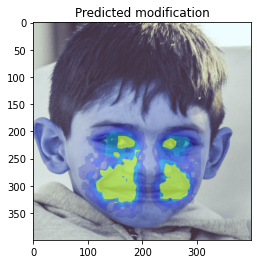

In [329]:
image = np.reshape(image,(h,w,3))
image = Image.fromarray(image,"RGB")
modified = image.resize((h, w),Image.BICUBIC)
modified_np = np.asarray(modified)
flow = flow_resize(real_flow, modified.size)
#print(flow.shape)
mag, ang = cv2.cartToPolar(flow[...,1], flow[...,0])
#print(mag.shape)
#print(modified_np.shape)
#save your image to the folder
path = "tester.png"
tester =get_heatmap_cv(modified_np,mag,max_flow_mag=12)
plt.title("Predicted modification")
plt.imshow(tester)

**plots the ground truth heatmap on the image**

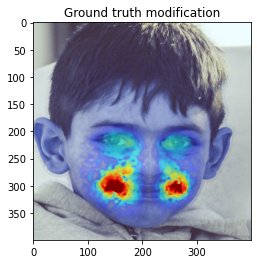

In [331]:

mag, ang = cv2.cartToPolar(ground_flow[...,0], ground_flow[...,1])
#print(mag.shape)
real = get_heatmap_cv(modified_np,mag,max_flow_mag=12)
plt.title("Ground truth modification")
plt.imshow(real)

In [ ]:
~